Imports and data loading. Warning are issued and a legend label is omitted, so it's been set to 'ignore'.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import warnings
warnings.filterwarnings("ignore")

data = pd.read_csv('pokemon.csv')

Adding new column 'generation'

In [2]:
data['generation'] = ''
data.loc[data.national_number <= 151, 'generation'] = 1
data.loc[(data.national_number >= 152) & (data.national_number <= 251), 'generation'] = 2
data.loc[(data.national_number >= 252) & (data.national_number <= 386), 'generation'] = 3
data.loc[(data.national_number >= 387) & (data.national_number <= 493), 'generation'] = 4
data.loc[(data.national_number >= 494) & (data.national_number <= 649), 'generation'] = 5
data.loc[(data.national_number >= 650) & (data.national_number <= 721), 'generation'] = 6
data.loc[(data.national_number >= 722) & (data.national_number <= 809), 'generation'] = 7
data.loc[(data.national_number >= 810) & (data.national_number <= 890), 'generation'] = 8

Removing Partner pokemons and setting Mega, Alolan and Galarian forms to gen 6, 7 and 8 respectively.
It also ignores pokemons with no base_stats_max. Full name includes pokemon species name.

In [3]:
prefix = []
data['ignore'] = False

for i, row in data.iterrows():
    fn_split = row['full_name'].split()
    if len(fn_split) != 1:
        if fn_split[0] == 'Partner':
            data.at[i,'ignore'] = True
        elif fn_split[0] == 'Mega':
            data.at[i,'generation'] = 6
        elif fn_split[0] == 'Alolan':
            data.at[i,'generation'] = 7
        elif fn_split[0] == 'Galarian':
            data.at[i,'generation'] = 8
        else:
            prefix.append(fn_split[0])
            
    if row['base_stats_max']=='{}':
        data.at[i,'ignore'] = True
    
    if row['name'] not in row['full_name']:
        data.at[i,'full_name'] = row['full_name'] + ' ' +row['name']
    

It removes ignored and duplicated pokemons, drops temp column 'ignore'

In [4]:
data = data[~data.ignore]
data.drop(['ignore'],axis=1,inplace=True)
data = data[~data.duplicated(subset=data.columns[2:])]

Function to expand dict value 'base_stats_max' into columns. 'att' key changed to column 'max_atk' for better comprehension.

In [5]:
def add_base_stats_max(row): 
    stats_dict = json.loads(row['base_stats_max'].replace("'",'"'))
    for k in stats_dict:
        col_name = 'max_'+k if k != 'att' else 'max_atk'
        row[col_name] = pd.to_numeric(stats_dict[k])
    return row

data = data.apply(add_base_stats_max, axis=1)

Function to display label over each bar in a bar chart. Taken from [here](https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/barchart.html).

In [6]:
def autolabel(bar_plot):
    """Attach a text label above each bar in *rects*, displaying its height."""
    rects = bar_plot.patches
    for rect in rects:
        height = rect.get_height()
        bar_plot.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 2),  
                    textcoords="offset points",
                    ha='center', va='bottom')

Function to plot top 5 pokemon with highest attribute of a given type

In [7]:
def plot_stat(stat, p_type=None):
    if p_type is not None:
        filtered_data = data[(data.type1==p_type) | (data.type2==p_type)]
        title = '{}-type Pokémons'.format(p_type)
    else:
        filtered_data = data
        title = 'Overall'
    max_stat = 'max_'+stat
    sliced = filtered_data.sort_values(by=max_stat,ascending=False)[:5][['full_name','name',max_stat]]
    sliced[max_stat] = pd.to_numeric(sliced[max_stat])
    sliced.index = sliced.full_name
    
    bar_plot = sliced[max_stat].plot(kind='bar',figsize=(15,10))
    autolabel(bar_plot)
    mean = filtered_data[max_stat].mean()
    bar_plot.hlines(mean,xmin=-1,xmax=5,color='r',linestyles='dashed',label='300')
    bar_plot.legend(['Mean ({0:.0f})'.format(round(mean)),'_stat'],loc='lower right')
    fig = bar_plot.get_figure()
    bar_plot.set_title('Highest {}s'.format(stat.capitalize()), fontsize=20)
    bar_plot.set_xlabel('')
    fig.suptitle(title, fontsize=20)

    for tick in bar_plot.get_xticklabels():
        tick.set_rotation(45)

    ylim = bar_plot.get_ylim()
    bar_plot.set_ylim(top=ylim[1]+15)

For each type, plot a 2 x 3 chart with top 5 pokemon for each attribute and save figure. It also plots a chart for top 5 pokemon of any type.

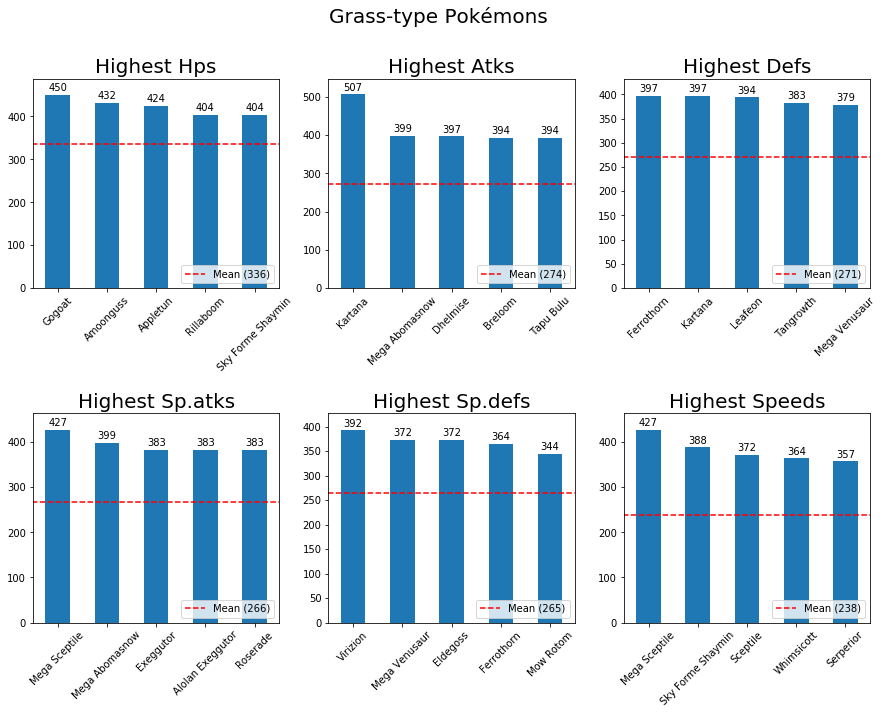

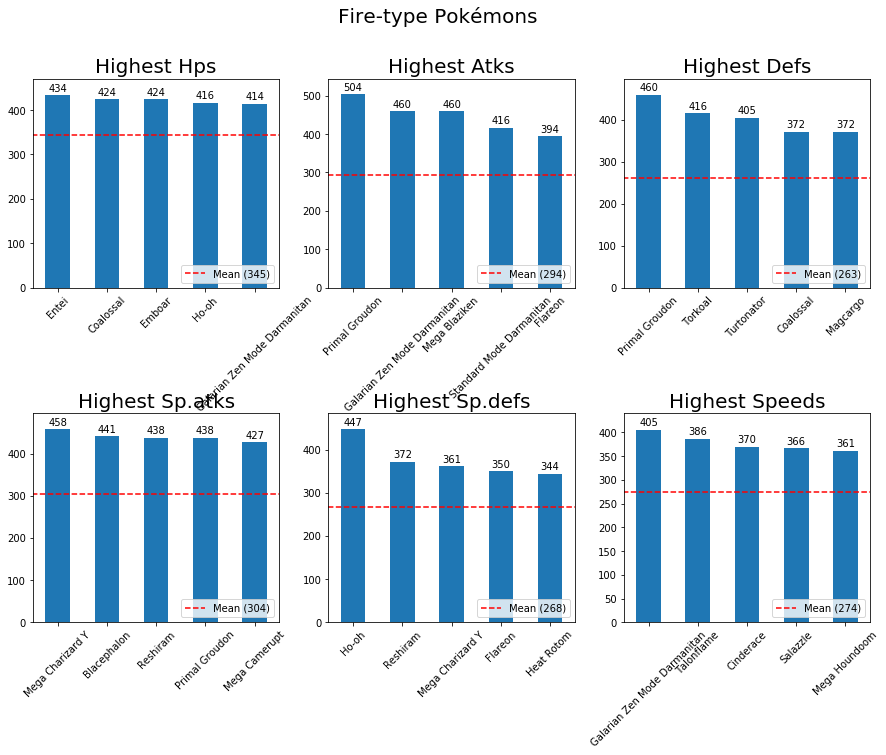

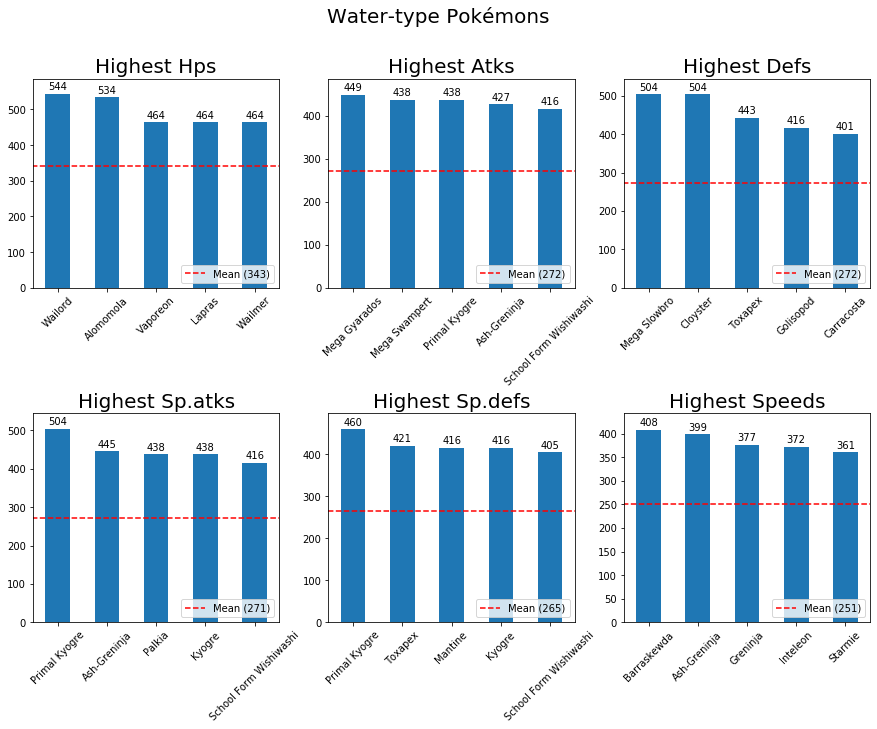

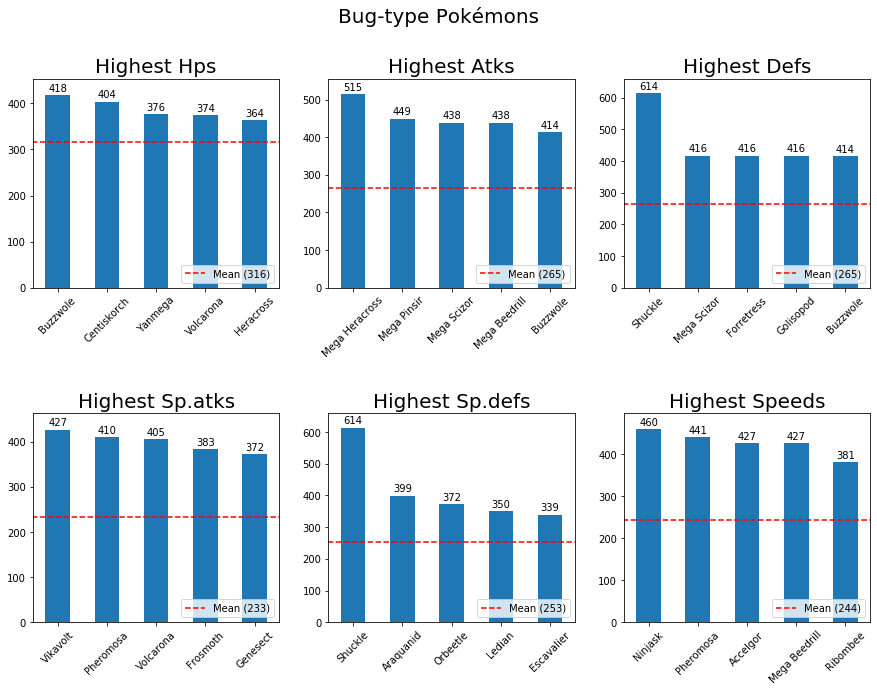

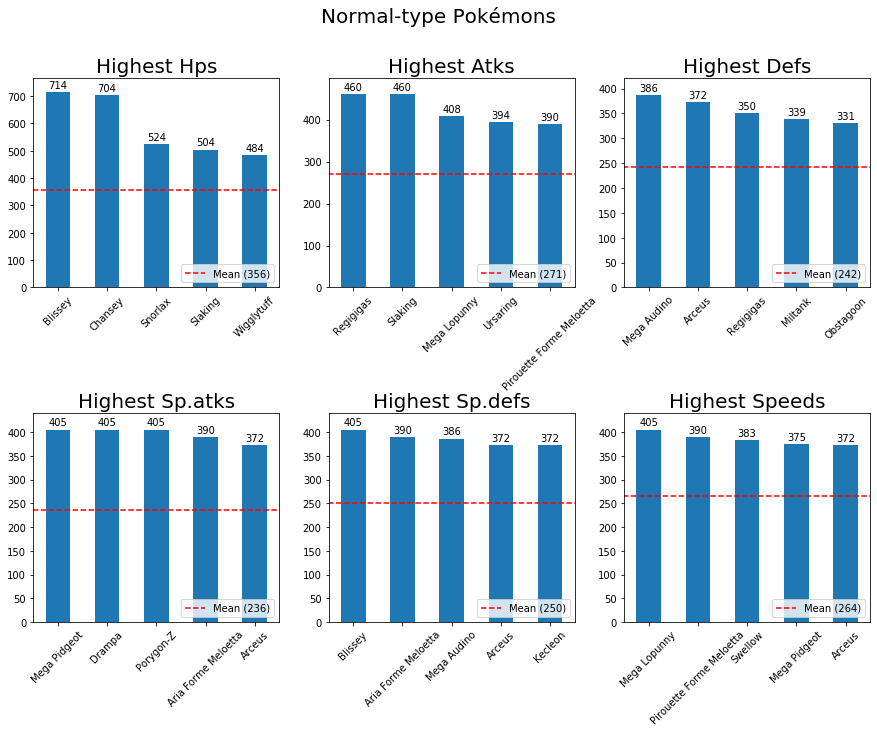

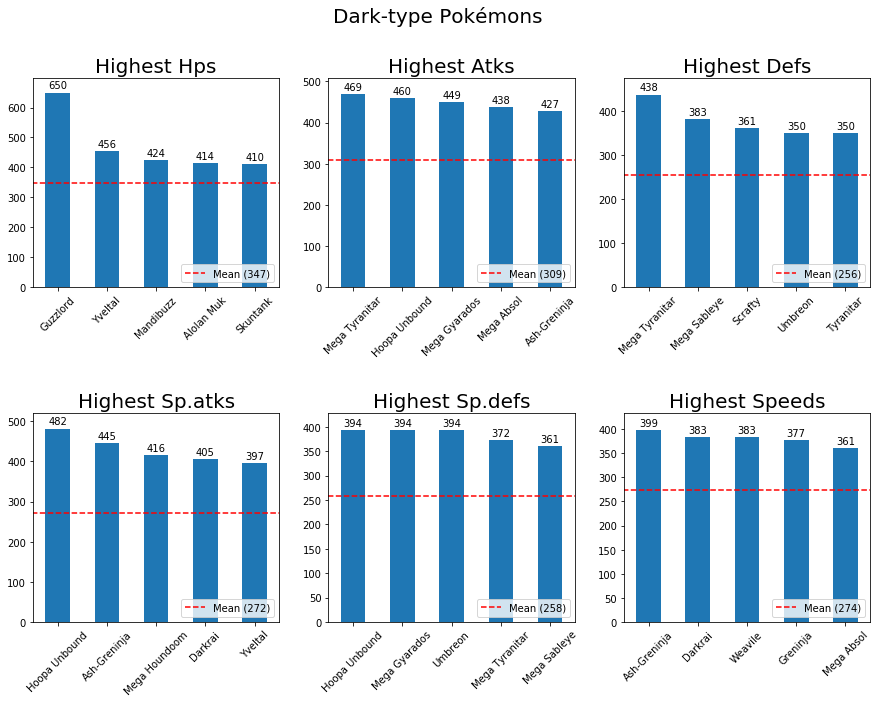

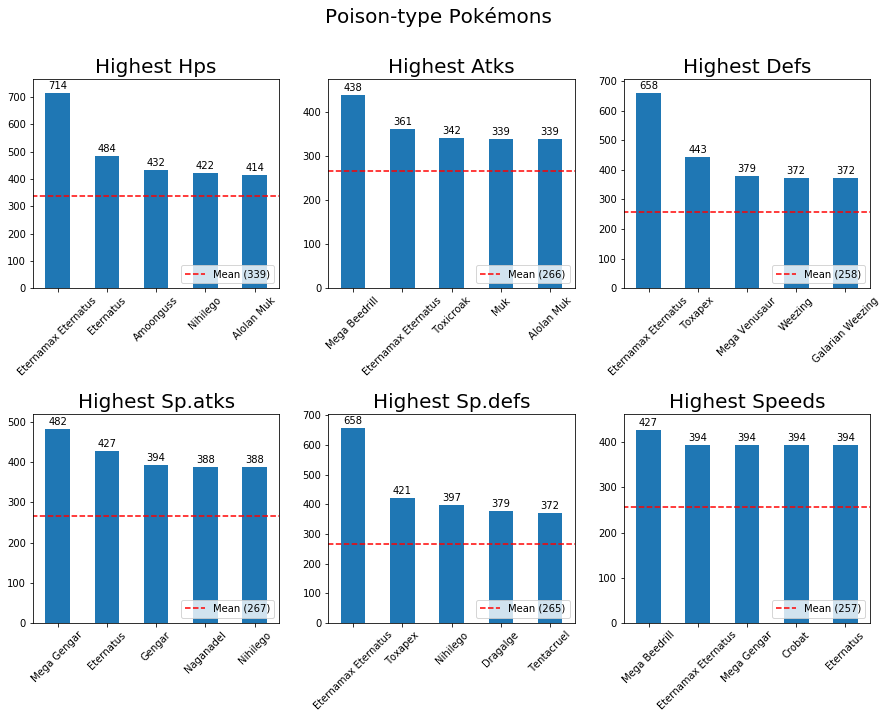

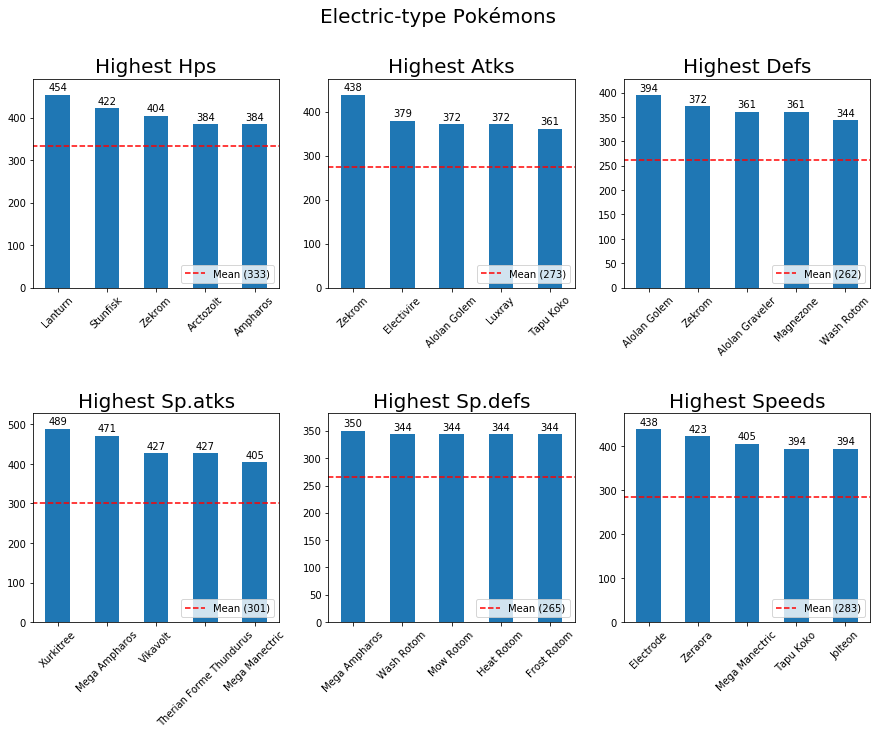

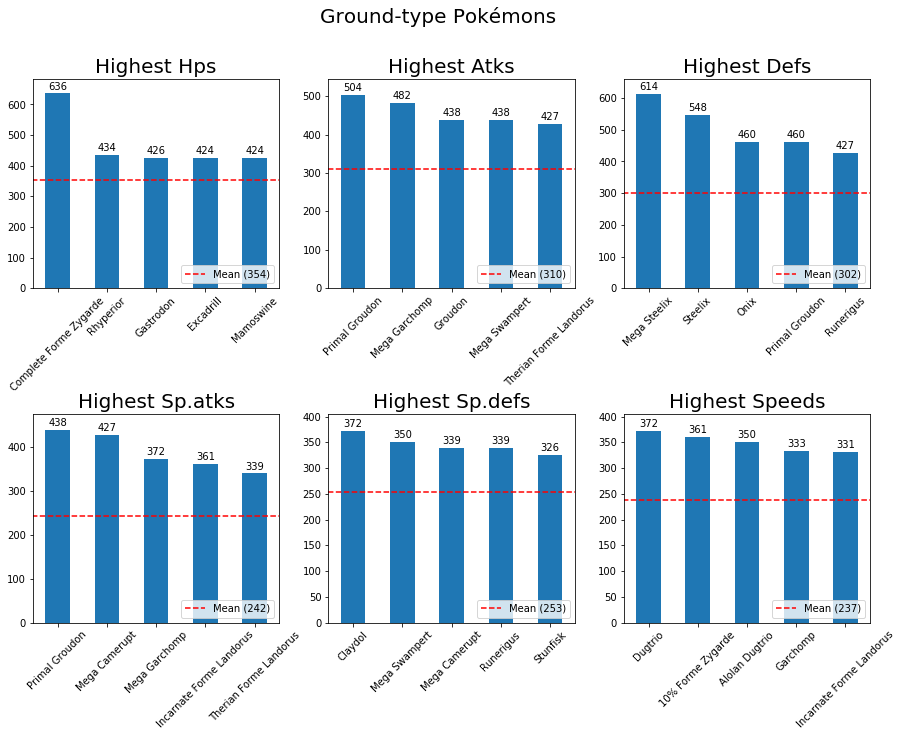

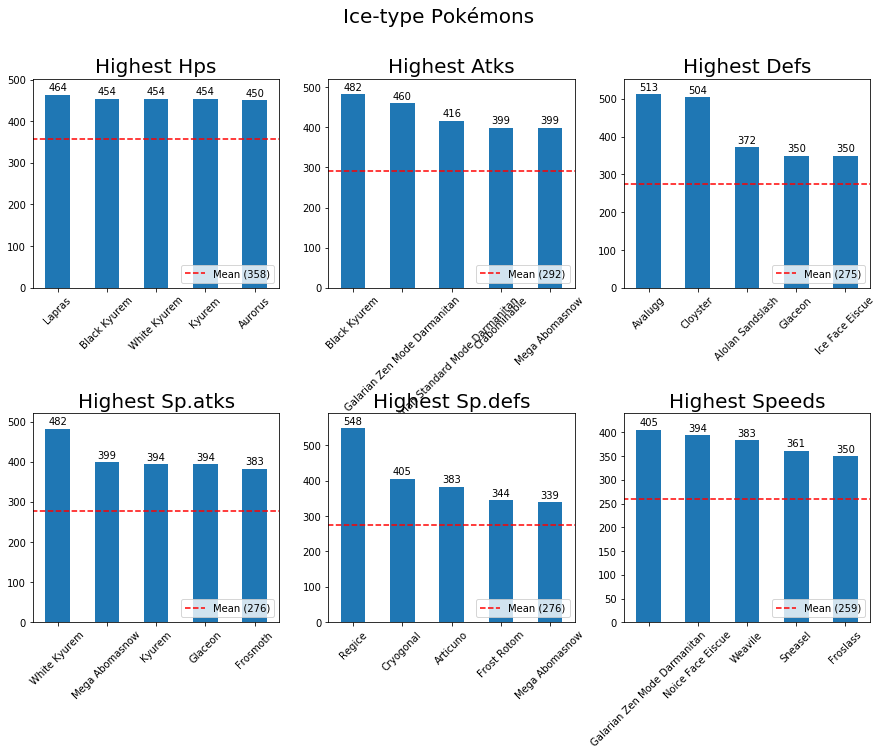

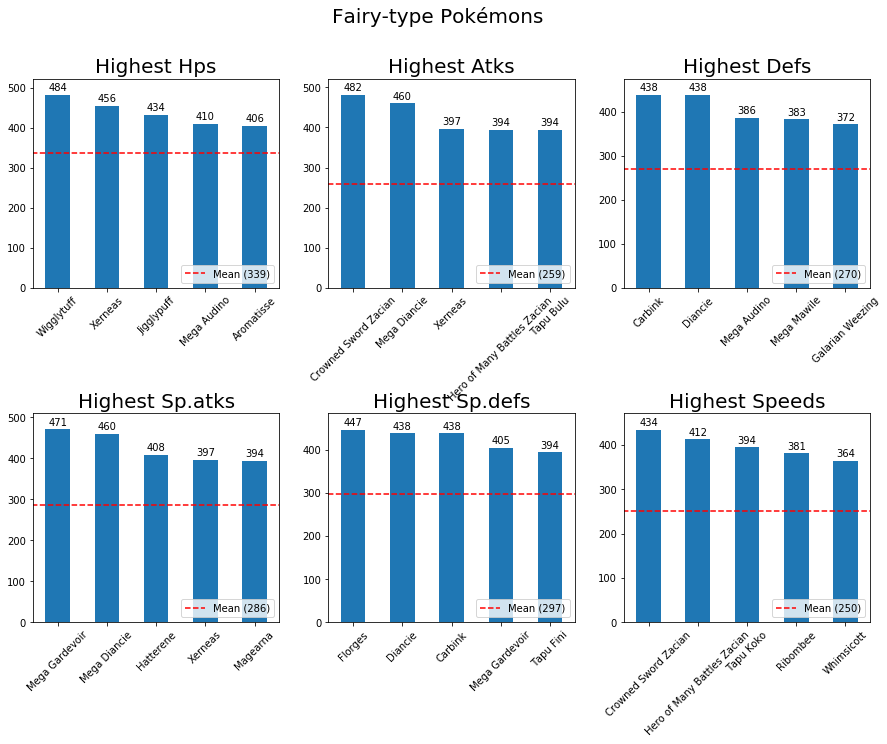

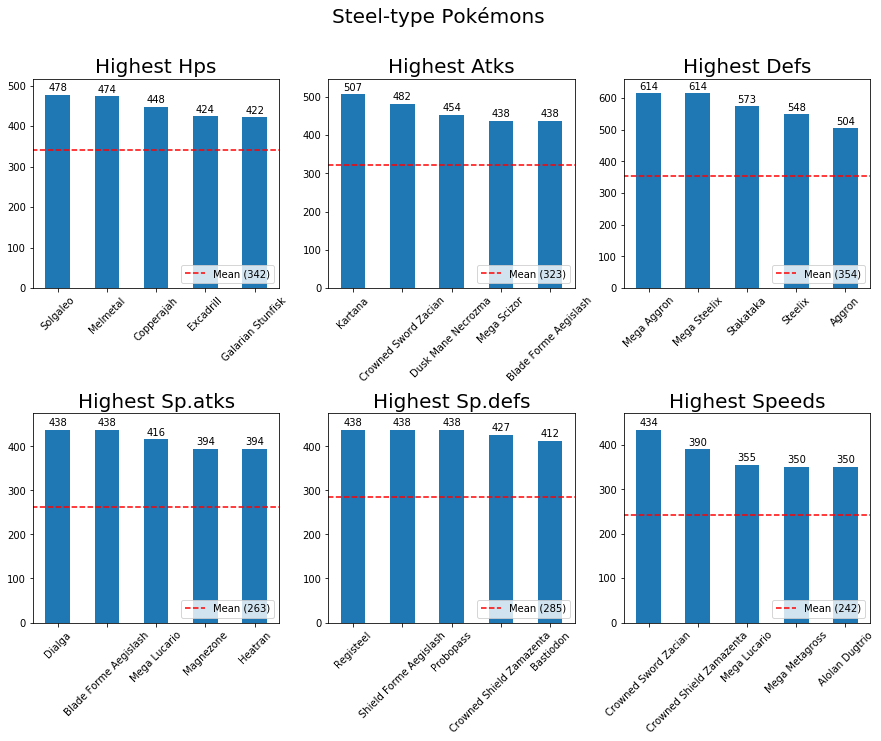

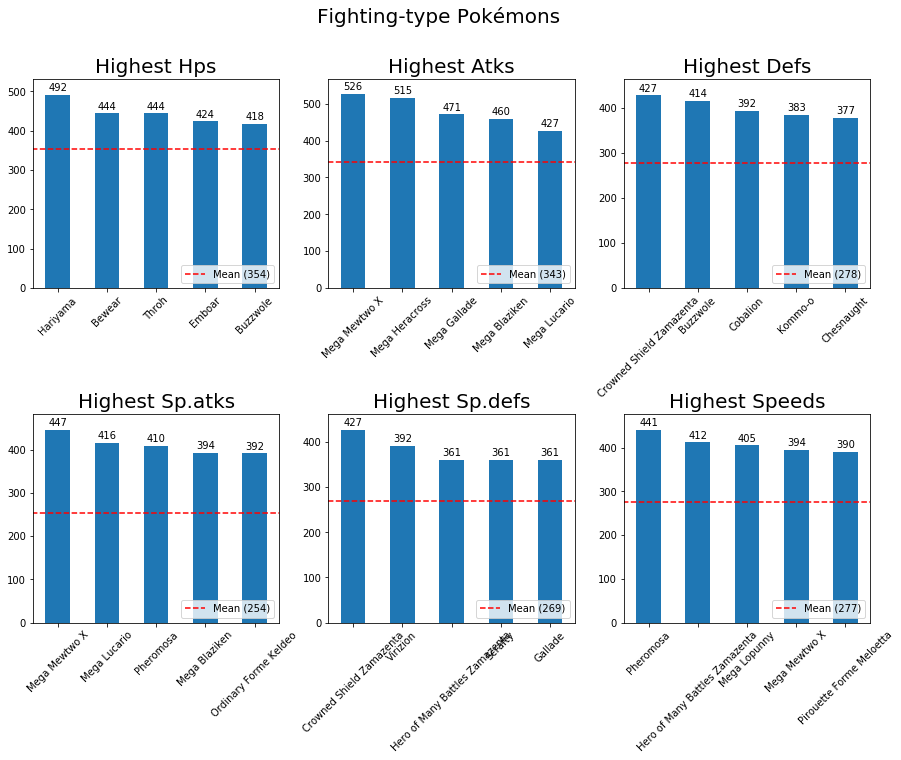

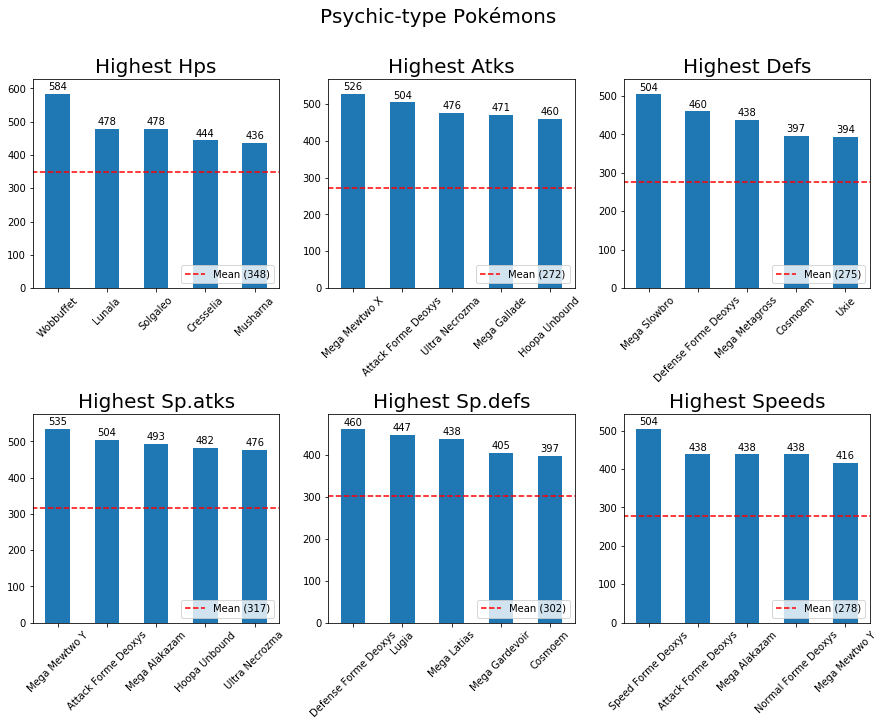

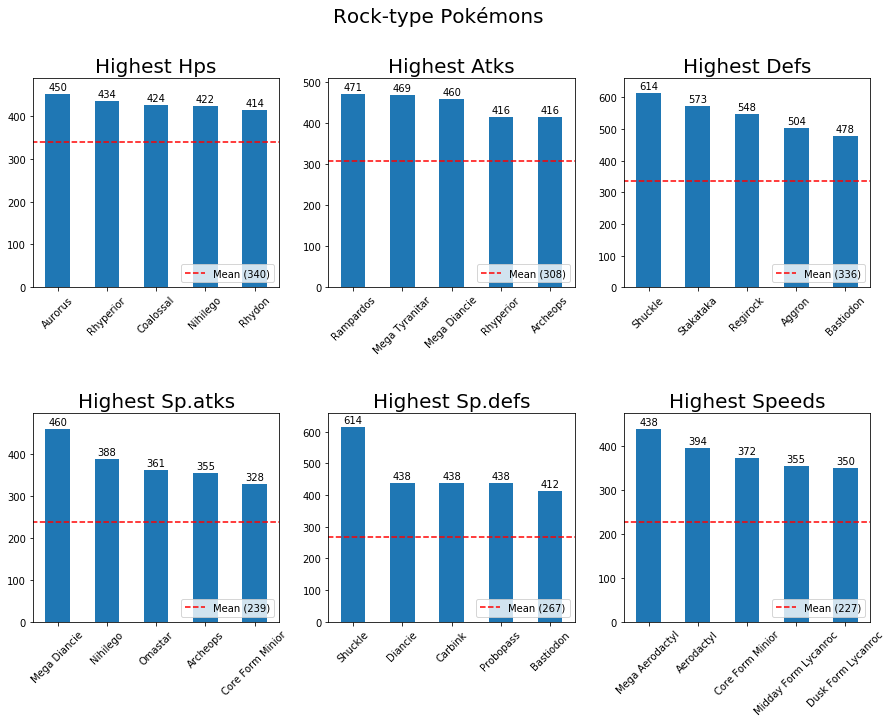

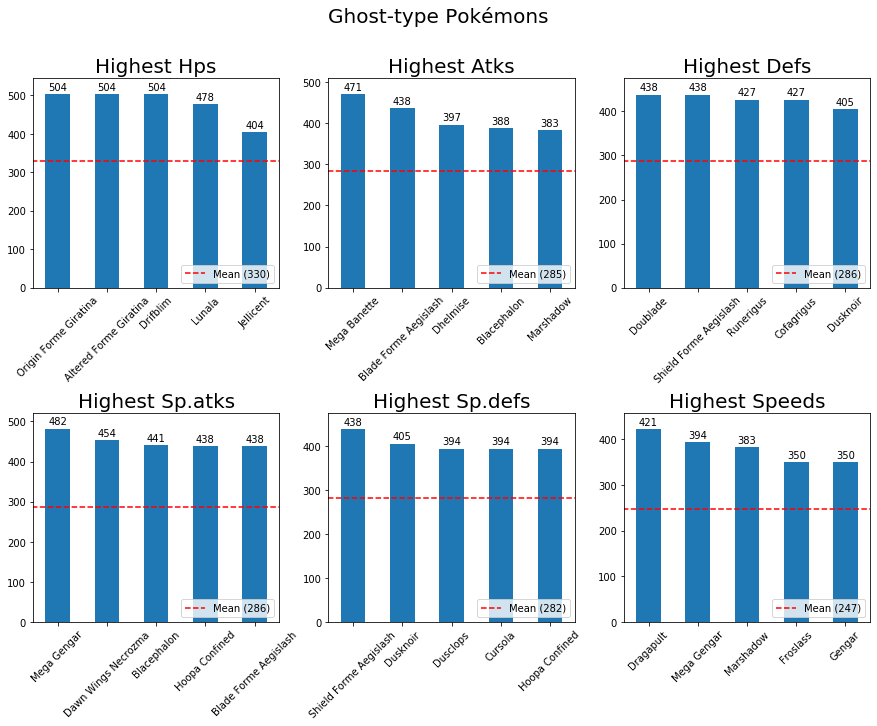

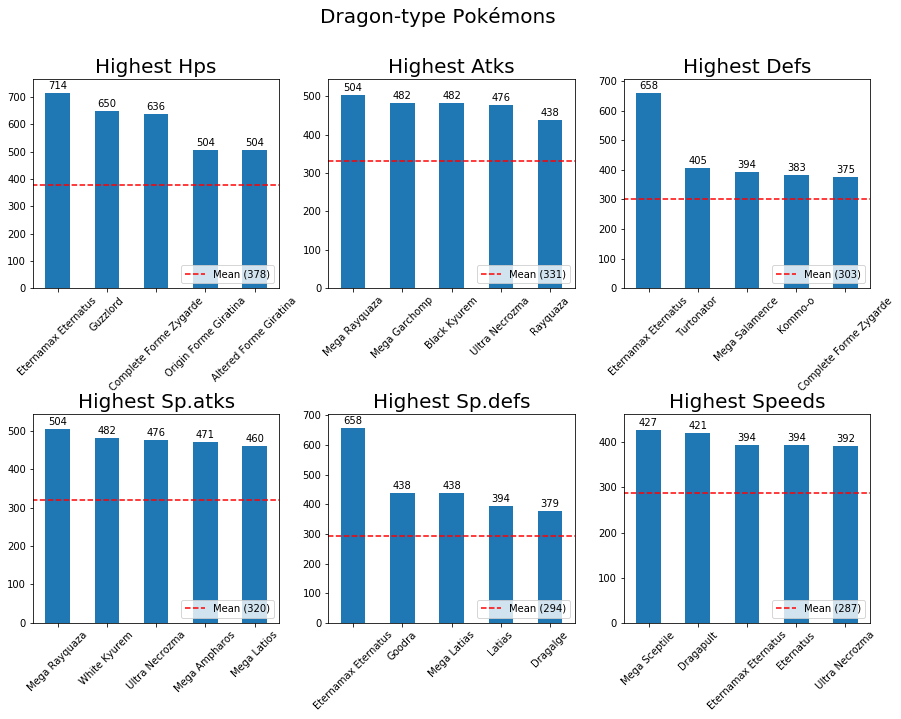

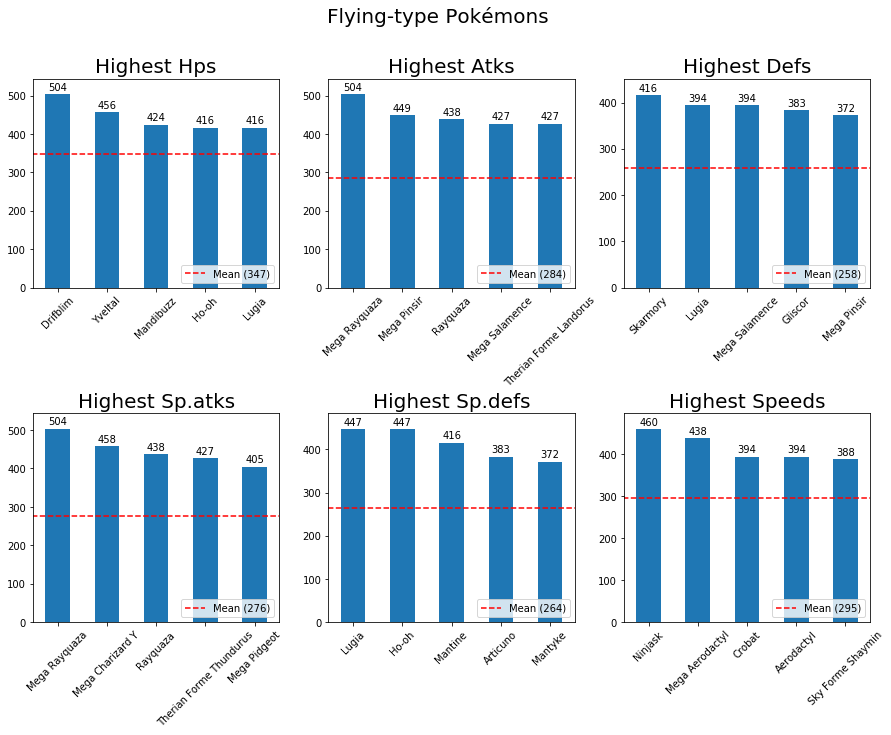

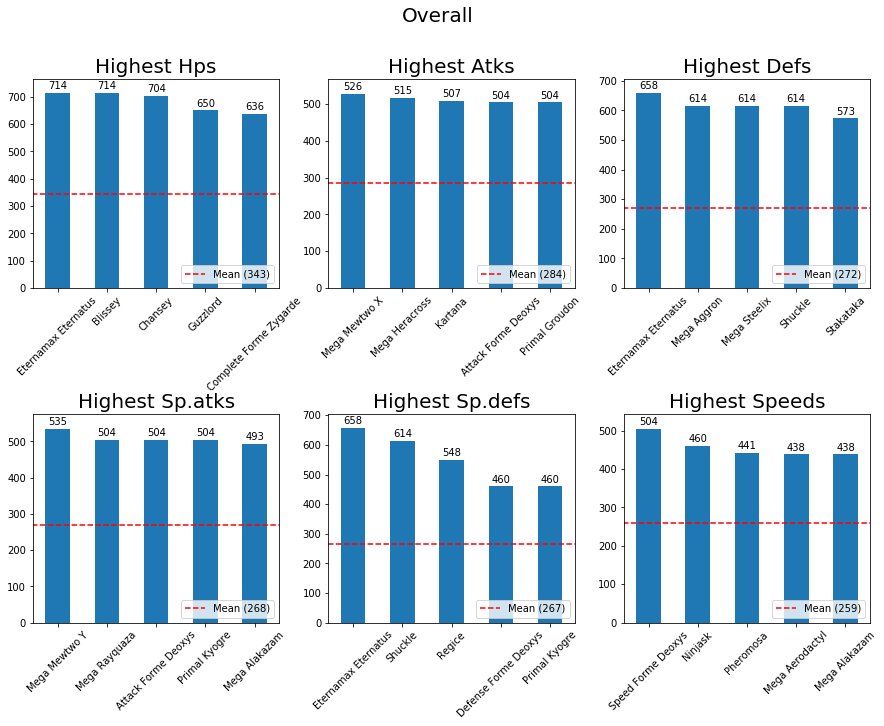

In [8]:
att_list = ('hp', 'atk', 'def', 'sp.atk', 'sp.def', 'speed')
p_types = np.append(data.type1.unique(),None)

for p_type in p_types:
    i = 1
    fig = plt.figure()
    for att in att_list:
        plt.subplot(2, 3, i)
        plot_stat(att, p_type)
        i += 1

    plt.subplots_adjust(hspace=0.6)
    if p_type is None:
        p_type = 'overall'
    fig.savefig(f'img/stats/highest_{p_type}_stats.png')